In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets as dsets
import torchvision.transforms as transforms
from torchvision import utils
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:

train_data = dsets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
image, label = train_data[0]

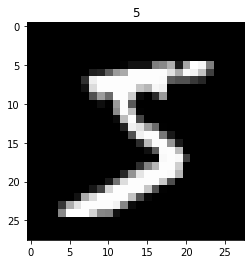

In [19]:
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('%i' % label)
plt.show()

In [20]:
batch_size = 200
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

train_data_loader = DataLoader(train_data, batch_size, shuffle=True)

In [28]:
d_noise = 100
d_hidden = 256
def sample_z(batch_size = 1 , d_noise=100):
    return torch.randn(batch_size,d_noise,device=device)

G = nn.Sequential(
    nn.Linear(64,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

z = sample_z()
img_fake = G(z).view(-1,28,28)
imshow(img_fake.squeeze().cpu().detach())

z = sample_z(batch_size=batch_size)
img_fake = G(z)
imshow_grid(img_fake)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 64x256)

In [22]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.5193, 0.5189, 0.5199, 0.5193, 0.5179]],
       grad_fn=<TransposeBackward0>)


In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [24]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad(): # 가중치를 0으로 초기화
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [29]:
num_epochs = 300
latent_size = 64

dx_epoch = []
dgx_epoch = []

total_step = len(train_data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        real_label = torch.ones(batch_size,1).to(device)
        fake_label = torch.zeros(batch_size,1).to(device)
        
        #--------------- Train the discriminator ---------------------
        
        outputs = D(images) 
        d_loss_real = criterion(outputs,real_label)
        real_score = outputs
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_label)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #----------------- Train the Generator ------------------------
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        g_loss = criterion(outputs, real_label)
        
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                        real_score.mean().item(), fake_score.mean().item()))
    dx_epoch.append(real_score.mean().item())            
    dgx_epoch.append(fake_score.mean().item())
    
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/300], Step [200/300], d_loss: 0.0011, g_loss: 7.5080, D(x): 1.00, D(G(z)): 0.00
Epoch [1/300], Step [200/300], d_loss: 0.0002, g_loss: 9.8844, D(x): 1.00, D(G(z)): 0.00
Epoch [2/300], Step [200/300], d_loss: 0.0000, g_loss: 11.2606, D(x): 1.00, D(G(z)): 0.00
Epoch [3/300], Step [200/300], d_loss: 0.0000, g_loss: 12.1752, D(x): 1.00, D(G(z)): 0.00
Epoch [4/300], Step [200/300], d_loss: 0.0000, g_loss: 12.6077, D(x): 1.00, D(G(z)): 0.00
Epoch [5/300], Step [200/300], d_loss: 0.0000, g_loss: 13.2053, D(x): 1.00, D(G(z)): 0.00
Epoch [6/300], Step [200/300], d_loss: 0.0000, g_loss: 13.5045, D(x): 1.00, D(G(z)): 0.00
Epoch [7/300], Step [200/300], d_loss: 0.0000, g_loss: 14.0879, D(x): 1.00, D(G(z)): 0.00
Epoch [8/300], Step [200/300], d_loss: 0.0000, g_loss: 14.6645, D(x): 1.00, D(G(z)): 0.00


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (12, 8))
plt.xlabel('epoch')
plt.ylabel('score')
x = np.arange(num_epochs)
plt.plot(x, dx_epoch, 'g', label='D(x)')
plt.plot(x, dgx_epoch, 'b', label='D(G(z))')
plt.legend()
plt.show()